# Классификация товаров
Основная идея данной части проекта - создание модели, классифицирующей текст-описание товаров в 4 категории (Electronics, Household, Books, and Clothing & Accessories)


## Начало
Подключим необходимые библиотеки, обьявим необходимые функции и константы.

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from collections import Counter
from gensim.models import Word2Vec


import re
import string
import contractions
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords



In [54]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer("[\w]+")
lemmatizer = WordNetLemmatizer()
BATCH_SIZE = 32

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nikitos_paravoz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nikitos_paravoz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Представление текста
Модели работают только с числовым представлением текстов, для чего необходимо строить их вектора, а для того, чтобы вектора были построены наиболее эффективным способом, нам надо очистить текст от "мусора", а также привести его в унифицированный вид.
Ниже представлены функции для обработки текста:

In [55]:
def text_lower(text):
    return text.lower()

def text_remove_whitespaces(text):
    return text.strip()

def text_lemm(text):
    return " ".join([lemmatizer.lemmatize(word) for word in tokenizer.tokenize(text)])

def text_remove_stopwords(text):
    text_no_stopwords = [word for word in tokenizer.tokenize(text) if word not in stop_words]
    return " ".join(text_no_stopwords)

def text_no_ascii(text):
    text = re.sub(r'[^\x00-\x7f]', '', text)
    return text

def text_remove_punct(text):
    text_no_punct = text.translate(str.maketrans('', '', string.punctuation))
    return text_no_punct

def text_expand_contractions(text):
    return contractions.fix(text)

def text_remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

def text_remove_long_words(text, max_len=10):
    words = text.split()
    short_words = [word for word in words if len(word) <= max_len]
    return ' '.join(short_words)

def text_remove_nonalph(text):
    return " ".join([word for word in tokenizer.tokenize(text) if word.isalpha()])


Сложим все эти функции в одну, ее то мы и будем использовать для обработки каждого описания товара.

In [56]:
def text_preprocess(text):
    text = text_expand_contractions(text)
    text = text_lower(text)
    text = text_remove_whitespaces(text)
    text = text_remove_punct(text)
    text = text_remove_stopwords(text)
    text = text_no_ascii(text)
    text = text_remove_nonalph(text)
    text = text_lemm(text)
    text = text_remove_short_words(text)
    text = text_remove_long_words(text)
    return text

## Подготовка данных
В задаче данные подают в виде csv файла, нам нужно из него получить датасет для обучения и тестирования.
Ниже представлена функция открывающая конвертирующая csv файл в датафрейм из pandas, далее его мы уже будем представлять в виде датасета.

In [57]:
def prepare_data(csv_path):
    data = pd.read_csv(csv_path)
    data.dropna(inplace=True)
    data.drop_duplicates(inplace=True)
    data.reset_index(drop=True, inplace=True)
    data.columns = ['category', 'description']
    category_dict = {'Household': 0, 'Books': 1, 'Clothing & Accessories': 2, 'Electronics' : 3}
    data.replace({'category' : category_dict}, inplace=True)
    return data


In [58]:
data = prepare_data('ecommerceDataset.csv')

In [59]:
data['clean_description'] = data['description'].apply(text_preprocess)

In [60]:
data['text_len'] = [len(text.split()) for text in data['clean_description']]

In [61]:
data = data[data['text_len'] < data['text_len'].quantile(0.95)]
data = data[data['text_len'] > 0]
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)
MAX_LEN = np.max(data['text_len'])

## Создание словаря и токенизация данных
Мы создадим словарь по корпусу наших текстов, добавив токены unk и pad.
Дополнительно сделаем так, чтобы словарь мы могли пополнять в будущем.
По словарю проведем токенизацию текстов.

In [63]:
def build_vocab(documents, existing_vocab=None):
    if existing_vocab is not None:
        vocab_dict = dict(existing_vocab)
    else:
        vocab_dict = {'<unk>' : 1}
    corpus = [word for text in documents for word in text.split()]
    count_words = Counter(corpus)
    for word, count in count_words.items():
        vocab_dict[word] = vocab_dict.get(word, 1) + count
    vocab = list(vocab_dict.items())
    vocab.sort(key=lambda x: x[1], reverse=True)
    vocab_to_int = {word:i+1 for i, (word,count) in enumerate(vocab)}
    return vocab, vocab_to_int


def huge_tokenize(documents, vocab_to_int):
    text_int = []
    for text in documents:
        r = [vocab_to_int.get(word, 1) for word in text.split()]
        r = torch.Tensor(r)
        text_int.append(r)
    text_int = pad_sequence(text_int, batch_first=True)
    return text_int

def small_tokenize(text, vocab_to_int, seq_len=MAX_LEN):
    r = [vocab_to_int.get(word, 1) for word in text.split()]
    if len(r) <= seq_len:
        zeros = list(torch.zeros(seq_len - len(r)))
        new = r + zeros
    else:
        new = r[: seq_len]
    return torch.Tensor(new).to(int)

In [64]:
X = data['clean_description']
y = data['category']
data_size = len(data)
indexs = [idx for idx in range(data_size)]
train_indices, test_indices = [], []
np.random.shuffle(indexs)
train_size = int(data_size * 0.8)
for i in range(data_size):
    if i < train_size:
        train_indices.append(indexs[i])
    else:
        test_indices.append(indexs[i])

In [65]:
vocabulary, vocabulary_to_int = build_vocab(X)
X_tok = huge_tokenize(X, vocabulary_to_int).to(int)

In [66]:
VOCAB_SIZE = len(vocabulary) + 1
EMBEDDING_DIM = 200

Воспользуемся для получения эмбеддинг-матрицы предобученной моделью  Word2Vec.

In [67]:
Word2vec_train_data = list(map(lambda x: x.split(), [X[idx] for idx in train_indices]))

In [68]:
model_obj = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)
w2v = model_obj.wv

In [69]:
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, token in vocabulary:
    if word in w2v.key_to_index:
        embedding_vector = w2v[word]
        embedding_matrix[token] = embedding_vector

In [70]:
X_train = [X_tok[idx] for idx in train_indices]
y_train = [y[idx] for idx in train_indices]
X_test = [X_tok[idx] for idx in test_indices]
y_test = [y[idx] for idx in test_indices]

In [71]:
class EcommerceDataset(Dataset):
    def __init__(self, x_vectorized, y):
        self.x_vectorized = x_vectorized
        self.y = y

    def __getitem__(self, index):
        return self.x_vectorized[index], self.y[index]

    def __len__(self):
        return len(self.x_vectorized)

In [72]:
train_dataset = EcommerceDataset(X_train, y_train)
test_dataset = EcommerceDataset(X_test, y_test)
trainval_size = len(train_dataset)
val_size = int(trainval_size * 0.15)
train_size = trainval_size - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [73]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
valid_loader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

## Модель
Для классификации воспользуемся LSTM сетью, с механизмом внимания.

In [131]:
NUM_CLASSES = 4
HIDDEN_DIM = 100
LSTM_LAYERS = 1

IS_BIDIRECTIONAL = True
LR = 1e-4
DROPOUT = 0.2
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [132]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, is_bidirectional):
        super(Attention, self).__init__()
        self.is_bidirectional = is_bidirectional
        self.attn = nn.Linear(hidden_dim * (4 if is_bidirectional else 2), hidden_dim * (2 if is_bidirectional else 1))
        self.v = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        if self.is_bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=-1)
        else:
            hidden = hidden[-1]
        hidden_repeated = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        attn_weights = torch.tanh(self.attn(torch.cat((hidden_repeated, encoder_outputs), dim=2)))
        attn_weights = self.v(attn_weights).squeeze(2)
        return nn.functional.softmax(attn_weights, dim=1)



class LSTM_Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, dropout, is_bidirectional):
        super(LSTM_Classifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = lstm_layers
        self.is_bidirectional = is_bidirectional

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, lstm_layers, batch_first=True, bidirectional=is_bidirectional)
        self.attention = Attention(hidden_dim, is_bidirectional)
        self.fc = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):

        embedded = self.embedding(x)

        out, hidden = self.lstm(embedded, hidden)
        attn_weights = self.attention(hidden[0], out)

        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)

        out = self.softmax(self.fc(context))
        return out, hidden

    def init_hidden(self, batch_size):

        factor = 2 if self.is_bidirectional else 1

        h0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        c0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        return (h0, c0)



In [133]:
model = LSTM_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS, DROPOUT, IS_BIDIRECTIONAL)
model = model.to(DEVICE)

In [134]:
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
model.embedding.weight.requires_grad = True

In [135]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

LSTM_Classifier(
  (embedding): Embedding(48806, 200, padding_idx=0)
  (lstm): LSTM(200, 100, batch_first=True, bidirectional=True)
  (attention): Attention(
    (attn): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=200, out_features=4, bias=True)
  (softmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.2, inplace=False)
)


### Обучение модели
Напишем функцию тестирования и обучения модели:

In [136]:
def evaluate(model, device, dataloader, loss_fn):
    losses  = []
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            h = model.init_hidden(y_batch.size(0))
            output, h = model(x_batch, h)
            
            loss = loss_fn(output, y_batch)
            losses.append(loss.item())

            y_pred = torch.argmax(output, dim=1)

            correct += torch.sum(y_pred==y_batch).item()
            total += y_batch.size(0)

    accuracy = round(100 * correct / total, 2)
    return accuracy, np.mean(losses)

In [175]:
def train(model, train_loader, device, loss_fn, optimizer, n_epoch=6):
    early_stopping_patience = 4
    early_stopping_counter = 0

    epoch_acc_max = 0
    for epoch in range(1, n_epoch + 1):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            h = model.init_hidden(y_batch.size(0))

            output, h = model(x_batch, h)

            optimizer.zero_grad()
            loss = loss_fn(output, y_batch)

            loss.backward()
            optimizer.step()



        epoch_accuracy, epoch_loss = evaluate(model, device, valid_loader, loss_fn)
        print(f"Epoch {epoch}/{n_epoch} finished: train_accuracy = {epoch_accuracy}%, train_loss = {epoch_loss}")
        if epoch_accuracy >= epoch_acc_max:
            torch.save(model.state_dict(), './state_dict.pt')
            print(f'Validation accuracy increased ({epoch_acc_max:.2f} --> {epoch_accuracy:.2f}).  Saving model ...')
            epoch_acc_max = epoch_accuracy
            early_stopping_counter = 0
        else:
            print(f'Validation accuracy did not increase')
            early_stopping_counter += 1
            
        if early_stopping_counter > early_stopping_patience:
            print('Early stopped at epoch :', epoch)
            break
    return model

In [171]:
model = train(model, train_loader, DEVICE, criterion, optimizer)

Epoch 1/6 finished: train_accuracy = 93.72%, train_loss = 0.23344985543921284
Epoch 1:Validation accuracy increased (0.00 --> 93.72).  Saving model ...
Epoch 2/6 finished: train_accuracy = 94.52%, train_loss = 0.20655615412991266
Epoch 2:Validation accuracy increased (93.72 --> 94.52).  Saving model ...
Epoch 3/6 finished: train_accuracy = 94.9%, train_loss = 0.1937044186669649
Epoch 3:Validation accuracy increased (94.52 --> 94.90).  Saving model ...
Epoch 4/6 finished: train_accuracy = 94.8%, train_loss = 0.18931563716495828
Epoch 4:Validation accuracy did not increase
Epoch 5/6 finished: train_accuracy = 94.96%, train_loss = 0.19230614575956548
Epoch 5:Validation accuracy increased (94.90 --> 94.96).  Saving model ...
Epoch 6/6 finished: train_accuracy = 93.4%, train_loss = 0.22517792462390296
Epoch 6:Validation accuracy did not increase


### Тестирование


Напишем функцию с понятным пользователю интерфейсом, для классификации одного текста.

In [190]:
def predict_single(text, temp=5):
    text = text_preprocess(text)
    text_tok = small_tokenize(text, vocabulary_to_int)
    inverse_category_list = ['Household', 'Books', 'Clothing & Accessories', 'Electronics']
    with torch.no_grad():
        x = text_tok.reshape(1, len(text_tok)).to(DEVICE)
        h =  model.init_hidden(1)
        emb = model.embedding(x)
        out, h = model.lstm(emb, h)
        attn_weights = model.attention(h[0], out)
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        _, important_tokens_base = torch.topk(attn_weights, temp, dim=1)
        for important_tokens in important_tokens_base:
            important_text = [text.split()[token.to(int)] for token in important_tokens if token.to(int) in range(0, len(text.split()))]
            print(important_text)
            out = model.softmax(model.fc(context))
            prediction = torch.argmax(out, dim=1)
            actual_length = len(text.split())
            colors = sns.color_palette("viridis", n_colors=actual_length)
            plt.figure(figsize=(actual_length, actual_length/10))
            bars = plt.bar(range(actual_length), attn_weights.squeeze(0)[:actual_length], color=colors)

            for i, bar in enumerate(bars):
                plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001, text.split()[i],
                        ha='center', va='bottom', rotation=25, fontsize=8, color='black')

            plt.xlabel("Words")
            plt.ylabel("Attention")
            plt.show()
        return inverse_category_list[prediction.to(int)]

In [188]:
model = LSTM_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS, DROPOUT, IS_BIDIRECTIONAL)
model.load_state_dict(torch.load('state_dict.pt'))
model.eval()

LSTM_Classifier(
  (embedding): Embedding(48806, 200, padding_idx=0)
  (lstm): LSTM(200, 100, batch_first=True, bidirectional=True)
  (attention): Attention(
    (attn): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=200, out_features=4, bias=True)
  (softmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.2, inplace=False)
)

['reader', 'featuring', 'new', 'model', 'ambitious']


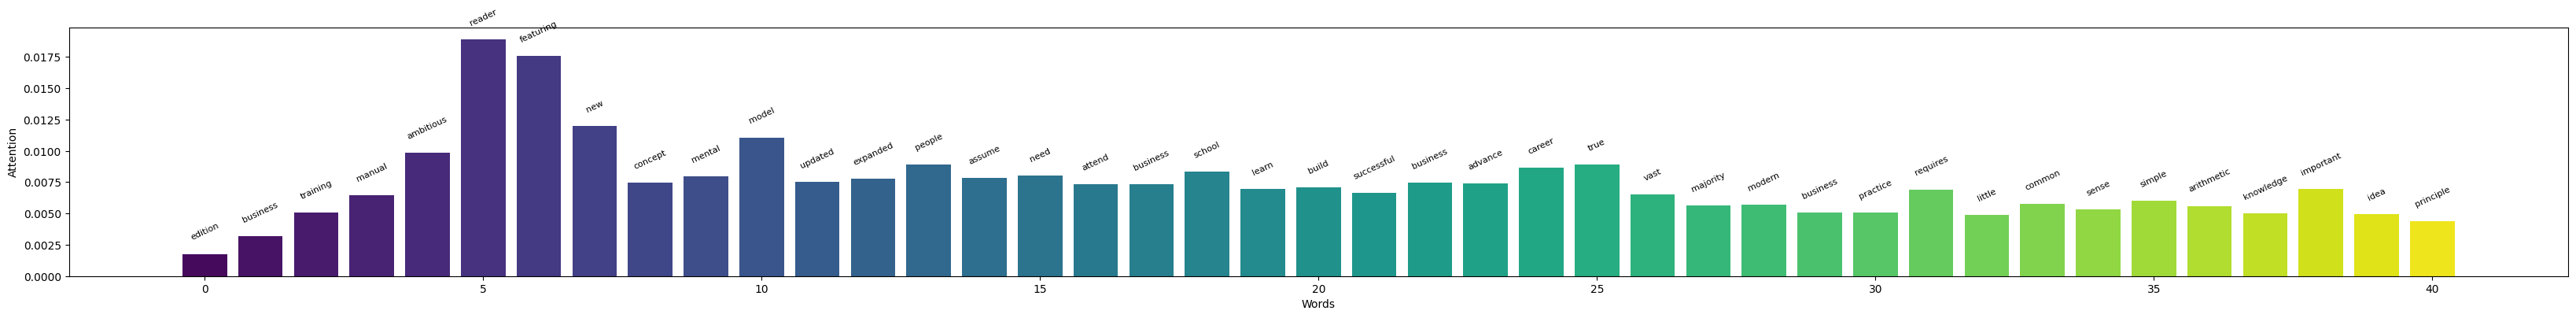

'Books'

In [191]:
predict_single('The 10th anniversary edition of the bestselling foundational business training manual for ambitious readers, featuring new concepts and mental models: updated, expanded, and revised.Many people assume they need to attend business school to learn how to build a successful business or advance in their career. Thats not true. The vast majority of modern business practice requires little more than common sense, simple arithmetic, and knowledge of a few very important ideas and principles')

Протестируем модель на тестовой выборке.

In [192]:
test_accuracy, test_loss = evaluate(model, DEVICE, test_loader, criterion)
print(f'Testing finished: Accuracy =  {test_accuracy}%, Loss = {test_loss}')

Testing finished: Accuracy =  94.55%, Loss = 0.1983093463974755


## Заключение
Мы получили оригинальную модель, которая работает хорошо, если к нам добавляют только продукты из описанных выше категорий :)